# Data basic exploration

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Data_looking.ipynb

# Import necessary libraries

# Load the datasets
stores = pd.read_csv('../data/stores.csv')
features = pd.read_csv('../data/features.csv')
train = pd.read_csv('../data/train.csv')

# Filter for only 3 stores and one department per store
selected_stores = [1, 2, 3]
selected_department = 1
train = train[(train['Store'].isin(selected_stores)) & (train['Dept'] == selected_department)]

# Merge the datasets on 'Store' and 'Date'
merged_df = pd.merge(train, features, on=['Store', 'Date'])
merged_df = pd.merge(merged_df, stores, on='Store')

# Convert the 'Date' column to the format dd/mm/yyyy
merged_df['Date'] = pd.to_datetime(merged_df['Date']).dt.strftime('%d/%m/%Y')

# Check if IsHoliday_x and IsHoliday_y are equal, if not set to NaN
merged_df['IsHoliday'] = merged_df.apply(lambda row: row['IsHoliday_x'] if row['IsHoliday_x'] == row['IsHoliday_y'] else pd.NA, axis=1)

# Remove IsHoliday_x and IsHoliday_y columns
merged_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'], inplace=True)

# Set MarkDown columns to zero until a certain date
certain_date = '01/01/2012'
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
merged_df.loc[merged_df['Date'] < certain_date, markdown_columns] = 0

# Display the first few rows of the merged dataframe
merged_df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday
0,1,1,05/02/2010,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,False
1,1,1,12/02/2010,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,True
2,1,1,19/02/2010,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,False
3,1,1,26/02/2010,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,False
4,1,1,05/03/2010,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,False


## Dealing with NaN values

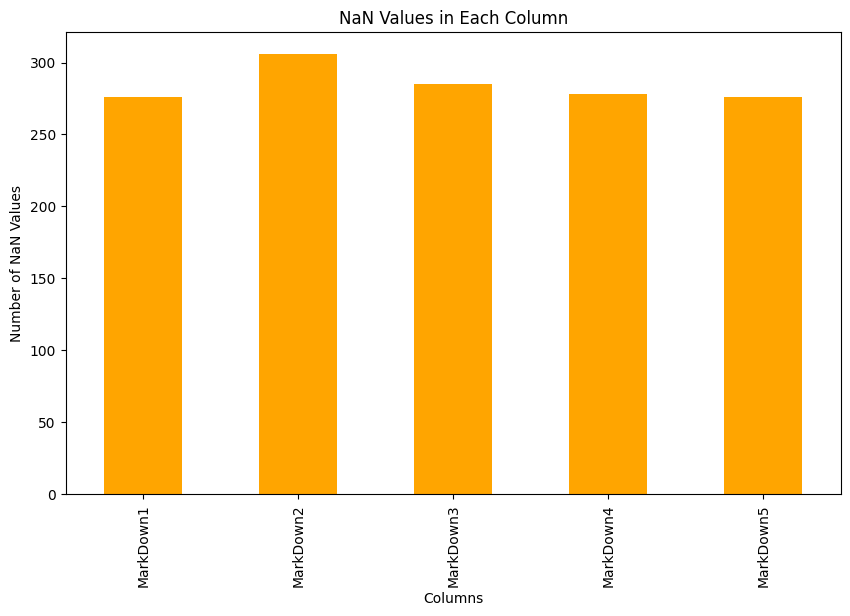

In [3]:
# Plotting the NaN values
plt.figure(figsize=(10, 6))
nan_values = merged_df.isna().sum()
nan_values = nan_values[nan_values > 0]
nan_values.plot(kind='bar', color='orange')
plt.title('NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

# Replace the NaN values in markdown with 0
merged_df = merged_df.fillna(0)

## Basic exploration

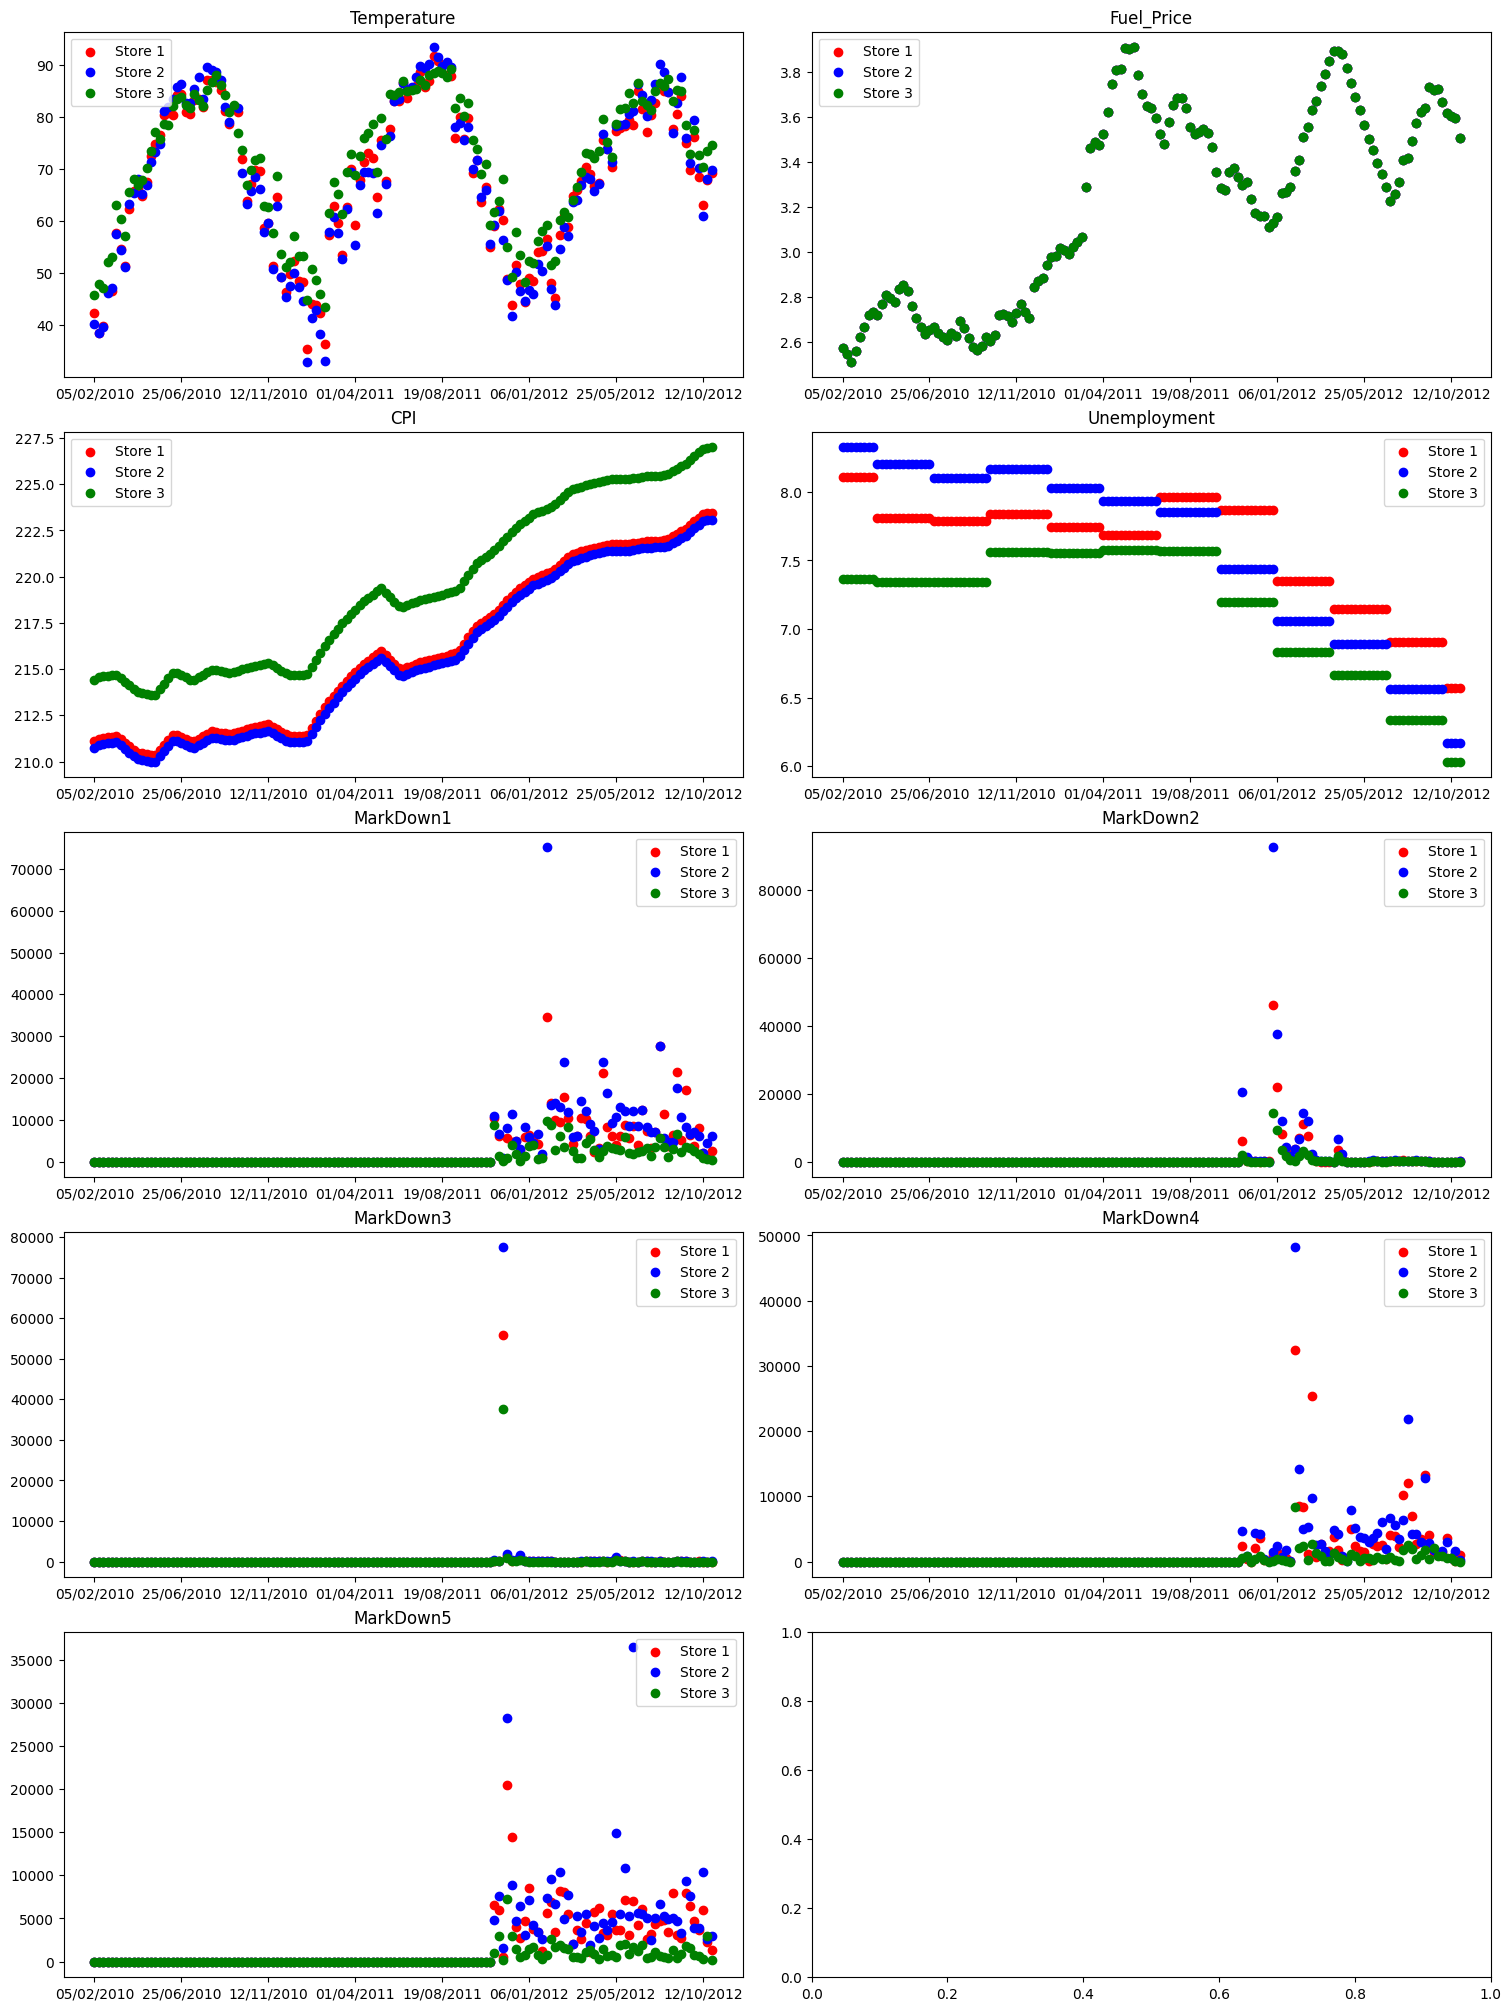

In [8]:
# Basic plots overview

# Plots for the different features in the df: 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), constrained_layout=True)
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
colors = {1: 'red', 2: 'blue', 3: 'green'}
for ax, feature in zip(axes.flatten(), features):
    for store in selected_stores:
        store_data = merged_df[merged_df['Store'] == store]
        ax.scatter(store_data['Date'], store_data[feature], label=f'Store {store}', color=colors[store])
    ax.set_title(feature)
    # Set equidistant x-axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    ax.legend()
plt.show()

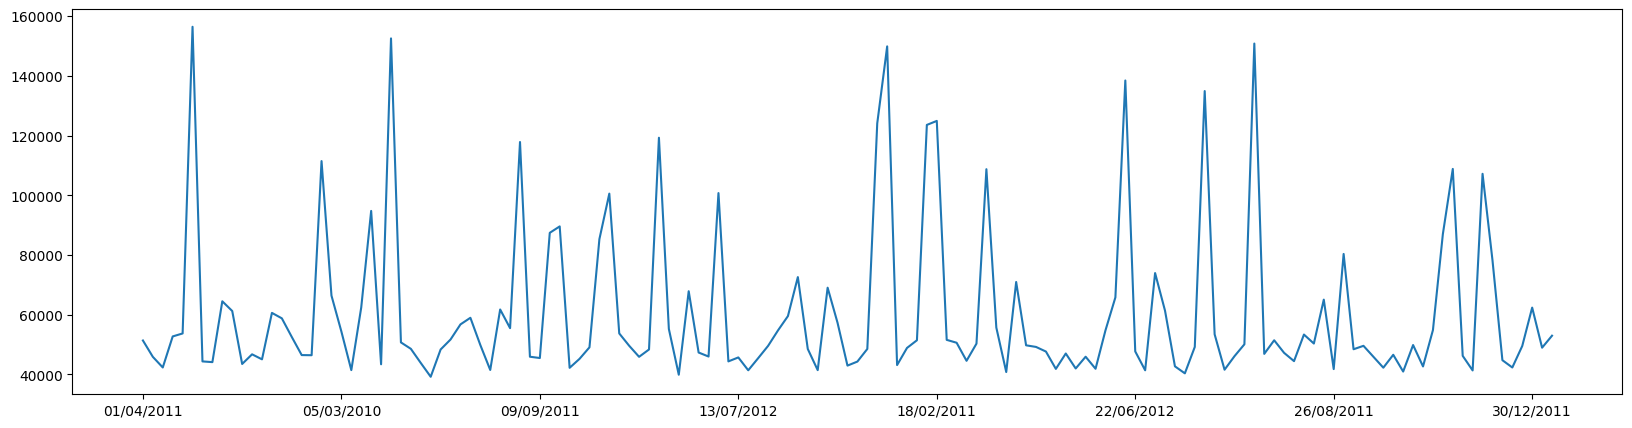

In [10]:
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = merged_df.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()

df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

#print(df_average_sales[:10])

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))